In [17]:
from IPython.display import Image, display
from models import get_model
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END, MessagesState

In [18]:
llm = get_model('azure')

# state["messages"][-2:] will return the last 2 elements from the messages list.

# If there are 2 or more elements, it returns the last 2.
# If there is only 1 element, it returns a list with that 1 element.
# If the list is empty, it returns an empty list.

class State(MessagesState):
    """State for the graph, inheriting from MessagesState."""
    summary: str

def call_modal(state: State):
    summary = state.get("summary", "")

    if summary:
        # Add summary to system Message
        messages = [SystemMessage(content=f"Summarize the following conversation: {summary}")] + state["messages"]
    else:
        # If no summary, just use the messages
        messages = state['messages']
    
    response = llm.invoke(messages)
    return {"messages": response}

# Define node to produce Summary

def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (f"This is summary of the conversation: {summary}\n\n"
                           "extend the summary by taking into account the new message above:")
    else:
        summary_message = "create summary of the conversation above:"
    
    messages = state['messages'] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]#state['messages'][:-2] if len(state['messages']) > 2 else state['messages']
    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State):
    #"return the next node to execute"

    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    
    return "end_conversation"


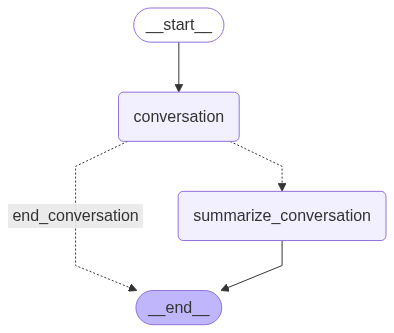

In [19]:
# Define the possible paths in a dictionary
path_map = {
    # The key is the string returned by should_continue
    # The value is the name of the destination node
    "summarize_conversation": "summarize_conversation",
    "end_conversation": END
}

#build Graph
graph_builder = StateGraph(State)
graph_builder.add_node("conversation", call_modal)
graph_builder.add_node("summarize_conversation", summarize_conversation)

graph_builder.add_edge(START, "conversation")
graph_builder.add_conditional_edges("conversation", should_continue, path_map)
graph_builder.add_edge("summarize_conversation", END)

#compile
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming Full State

2 methods are there .stream(sync), .astream (async) methods

These Streams are having different Modes (values, updates)




In [20]:
#create a thread
config = {"configurable": {"thread_id": "1"}}

#Start Conversation
for chunk in graph.stream({"messages": [HumanMessage(content="Hello, I am Ashutosh.")]}, config, stream_mode="updates"):
    chunk["conversation"]["messages"].pretty_print()

================================== Ai Message ==================================

Hello, Ashutosh! 😊 It's great to meet you. How can I assist you today?


In [22]:
#Start conversation with values mode
config = {"configurable": {"thread_id": "2"}}

#Start Conversation
for chunk in graph.stream({"messages": [HumanMessage(content="Hello, I am Ashutosh.")]}, config, stream_mode="values"):
    for m in chunk['messages']:
        m.pretty_print()
    print("--***--"*25)


================================ Human Message =================================

Hello, I am Ashutosh.
================================== Ai Message ==================================

Hello, Ashutosh! 😊 It's great to meet you. How can I assist you today?
================================ Human Message =================================

Hello, I am Ashutosh.
--***----***----***----***----***----***----***----***----***----***----***----***----***----***----***----***----***----***----***----***----***----***----***----***----***--
================================ Human Message =================================

Hello, I am Ashutosh.
================================== Ai Message ==================================

Hello, Ashutosh! 😊 It's great to meet you. How can I assist you today?
================================ Human Message =================================

Hello, I am Ashutosh.
================================== Ai Message ==================================

Hello again, Ashutos

## astrem event

In [23]:
#Start conversation with values mode
config = {"configurable": {"thread_id": "5"}}
node_to_stream = 'conversation'
#Start Conversation
async for event in graph.astream_events({"messages": [HumanMessage(content="tell me about 49ers NFL team")]}, config):
    if event["event"] == "on_chat_model_stream" and event["metadata"].get('langgraph_node', '') == node_to_stream:
        data = event["data"]
        print(data['chunk'].content, end='|')

||The| **|San| Francisco| |49|ers|**| are| a| professional| football| team| based| in| the| San| Francisco| Bay| Area|.| They| compete| in| the| National| Football| League| (|NFL|)| as| a| member| of| the| **|National| Football| Conference| (|N|FC|)| West| division|**|.| The| |49|ers| are| one| of| the| most| stor|ied| franchises| in| NFL| history|,| boasting| a| rich| history|,| numerous| championships|,| and| legendary| players|.

|---

|##| **|Fr|anchise| Overview|**

|-| **|Founded|**|:| |194|6|  
| | The| team| was| initially| part| of| the| All|-Amer|ica| Football| Conference| (|AA|FC|)| and| joined| the| NFL| in| |194|9| after| the| AA|FC| dissolved|.|  
|-| **|Team| Name|**|:| The| team| is| named| after| the| prospect|ors| who| arrived| in| Northern| California| during| the| **|California| Gold| Rush| of| |184|9|**|.|  
|-| **|Team| Colors|**|:| **|Red|,| Gold|,| White|**|  
|-| **|Masc|ot|**|:| **|S|ourd|ough| Sam|**|  
|-| **|Home| Stadium|**|:|  
| | -| **|Le|vi|'s| Stadium